In [3]:
include("../src/viral_load_infectivity_testpos.jl")
using StatsPlots

In [27]:
function calc_infectious_potential_reduction(test_days::Array{Int64,1}, day_start::Int64,
            VL_profile::Array{Float64,1}, VL_mag::Float64, test_pos_profile::Array{Float64,1},
            will_isolate::Bool, symp_day::Int64, NCP::Float64, delay::Int64 = 0)
    
    test_daysh = test_days .+ day_start
    #trim to test days within VL trajectory
    valid_days = test_daysh[test_daysh .< length(VL_profile)]
    #baseline infection profile
    inf_profile0 = 2 * VL_profile / VL_mag
    inf_profile0[inf_profile0 .< 0] .= 0
    inf_profile = copy(inf_profile0)
    testneg = true  #repeat tests until we get a positive (then assumed quarantined)
    itest = 1
    while testneg == true && itest <= length(valid_days)
        d = valid_days[itest]
        tp = (rand() < NCP*test_pos_profile[d])  #assume non compliance is independent each time
        if tp && (d+delay <= length(inf_profile))
            inf_profile[(d+delay):end] .= 0
            testneg = false
        end
        itest += 1
    end
    if will_isolate   #symptomatic isolation alters both tested and original profile
        inf_profile[(symp_day+1):end] .= 0
        inf_profile0[(symp_day+1):end] .= 0
    end
    if sum(inf_profile0) > 0
        p_infected = 1 - (sum(inf_profile) / sum(inf_profile0))   #reduction in infectious potential
    else
        p_infected = 0  #should be rare
    end
    
    return p_infected
end

calc_infectious_potential_reduction (generic function with 2 methods)

In [28]:
Ntrials = 50000

50000

Testing with no symptomatic self isolation -- LFDs


In [29]:
Pisol = 0.0
NewPisol = [0.25, 0.5,0.75,1.0]  #adherence to test result
TestFreq = 2:2:14
p_reduction = zeros(length(NewPisol),length(TestFreq),Ntrials)

for (j,p) in enumerate(NewPisol)
    for (n,f) in enumerate(TestFreq)
        sim = init_VL_and_infectiousness(Ntrials, Pisol)
        testing_params = Dict("protocol"=>LFD_mass_protocol,"tperiod"=>f,
                              "new_comply_prob"=>p)
        init_testing!(sim, testing_params, 1, 50)
        test_days = collect(1:f:50)
        #work out probability of avoiding infection for each case
        for m in 1:Ntrials
            day_start = rand(0:(f-1))   
            p_reduction[j,n,m] = calc_infectious_potential_reduction(test_days, day_start,
                       sim["VL_profiles"][m], sim["VL_mag"][m], 
                       sim["test_pos_profiles"][m], sim["will_isolate"][m], 
                       sim["symp_day"][m], p)
        end
    end
end
dftest_noisol = DataFrame([Float64,Float64,Int64,Float64],[:TestFreq,:NCP,:Iter,:p_inf],length(p_reduction))
n = 1
for i in 1:length(TestFreq)
    for j in 1:length(NewPisol)
        dftest_noisol["TestFreq"][n:(n+Ntrials-1)] .= TestFreq[i]
        dftest_noisol["NCP"][n:(n+Ntrials-1)] .= NewPisol[j]
        dftest_noisol["Iter"][n:(n+Ntrials-1)] = collect(1:Ntrials)
        dftest_noisol["p_inf"][n:(n+Ntrials-1)] .= p_reduction[j,i,:]
        n += Ntrials
    end
end

In [58]:
colors = Array{RGBA{Float64}}(undef,length(p_reduction))
barcolor=[RGBA(0.1, 0.4, 1.0, 0.25), RGBA(0.1, 0.4, 1.0, 0.5),
          RGBA(0.1, 0.4, 1.0, 0.75), RGBA(0.1, 0.4, 1.0, 1.0)]
i = 1
for ncp in NewPisol
    colors[dftest_noisol["NCP"] .== ncp] .= barcolor[i]
    i += 1
end

gr(size=(800,300))
p = @df dftest_noisol StatsPlots.groupedboxplot(:TestFreq,:p_inf,group=:NCP,ylim=(-0.01,1.01),
         outliers=false, xlabel="Days between tests",
         ylabel="Reduction in infection potential (p)", 
         color = colors,
         xticks=2:2:14,yticks=0:0.1:1.0,margin=5Plots.mm)
savefig(p,"compliance_effect_Pisol0_domcare.png")

In [ ]:
#lfd_testing -- with isolation
#pcr_testing -- with delay
Pisol = 0.0
TestFreq = 2:2:14
TestTypes = ["LFD","PCR - 0 day delay","PCR - 1 day delay","PCR - 2 day delay"]
p_reduction = zeros(length(TestTypes),length(TestFreq),Ntrials)
VLs = zeros(length(TestFreq),Ntrials)
for (n,f) in enumerate(TestFreq)
    simLFD = sim = init_VL_and_infectiousness(Ntrials, Pisol)
    testing_paramsLFD = Dict("protocol"=>LFD_mass_protocol,"tperiod"=>f,
                              "new_comply_prob"=>1.0)
    simPCR = copy(simLFD)  #do for same individuals
    
    init_testing!(simLFD, testing_paramsLFD, 1, 50)
    testing_paramsPCR = Dict("protocol"=>PCR_mass_protocol,"tperiod"=>f,
                          "new_comply_prob"=>1.0)
    init_testing!(simPCR, testing_paramsPCR, 1, 50)
    test_days = collect(1:f:50)
    
    #work out probability of avoiding infection for each case
    for m in 1:Ntrials
        day_start = rand(0:(f-1))
        p_reduction[1,n,m] = calc_infectious_potential_reduction(test_days, day_start,
                       simLFD["VL_profiles"][m], simLFD["VL_mag"][m], 
                       simLFD["test_pos_profiles"][m], simLFD["will_isolate"][m], 
                       simLFD["symp_day"][m], 1.0)
        p_reduction[2,n,m] = calc_infectious_potential_reduction(test_days, day_start,
                       simPCR["VL_profiles"][m], simPCR["VL_mag"][m], 
                       simPCR["test_pos_profiles"][m], simPCR["will_isolate"][m], 
                       simPCR["symp_day"][m], 1.0, 0)
        p_reduction[3,n,m] = calc_infectious_potential_reduction(test_days, day_start,
                       simPCR["VL_profiles"][m], simPCR["VL_mag"][m], 
                       simPCR["test_pos_profiles"][m], simPCR["will_isolate"][m], 
                       simPCR["symp_day"][m], 1.0, 1)
        p_reduction[4,n,m] = calc_infectious_potential_reduction(test_days, day_start,
                       simPCR["VL_profiles"][m], simPCR["VL_mag"][m], 
                       simPCR["test_pos_profiles"][m], simPCR["will_isolate"][m], 
                       simPCR["symp_day"][m], 1.0, 2)
        VLs[n,m] = simLFD["VL_mag"][m]
    end
end
dftest_noisol_LP = DataFrame([Float64,String,Int64,Float64,Float64],[:TestFreq,:TestType,:Iter,:p_inf,:peakVL],
              length(p_reduction))

n = 1
for j in 1:length(TestTypes)
    for i in 1:length(TestFreq)
        dftest_noisol_LP["TestFreq"][n:(n+Ntrials-1)] .= TestFreq[i]
        dftest_noisol_LP["TestType"][n:(n+Ntrials-1)] .= TestTypes[j]
        dftest_noisol_LP["Iter"][n:(n+Ntrials-1)] .= collect(1:Ntrials)
        dftest_noisol_LP["p_inf"][n:(n+Ntrials-1)] .= p_reduction[j,i,:]
        dftest_noisol_LP["peakVL"][n:(n+Ntrials-1)] .= VLs[i,:]
        n += Ntrials
    end
end

In [56]:
colors = Array{RGBA{Float64}}(undef,length(p_reduction))
barcolor=[RGBA(0.1, 0.4, 1.0, 1.0), RGBA(1.0, 0.55, 0.0, 1.0), 
         RGBA(1.0, 0.55, 0.0, 0.6), RGBA(1.0, 0.55, 0.0, 0.2)]
i = 1
for tt in TestTypes
    colors[dftest_noisol_LP["TestType"] .== tt] .= barcolor[i]
    i += 1
end

gr(size=(800,300))
plot = @df dftest_noisol_LP StatsPlots.groupedboxplot(:TestFreq,:p_inf,group=:TestType,ylim=(-0.01,1.01),
         outliers=false, xlabel="Days between tests",
         ylabel="Reduction in infection potential (p)",
         color = colors,
         xticks=2:2:14,yticks=0:0.1:1.0, margin=5Plots.mm)
savefig(plot,"test_effect_Pisol0_domcare.png")

In [33]:
#lfd_testing -- with isolation
#pcr_testing -- with delay
Pisol = 1.0
TestFreq = 2:2:14
TestTypes = ["LFD","PCR - 0 day delay","PCR - 1 day delay","PCR - 2 day delay"]
p_reduction = zeros(length(TestTypes),length(TestFreq),Ntrials)
VLs = zeros(length(TestFreq),Ntrials)
for (n,f) in enumerate(TestFreq)
    simLFD = sim = init_VL_and_infectiousness(Ntrials, Pisol)
    testing_paramsLFD = Dict("protocol"=>LFD_mass_protocol,"tperiod"=>f,
                              "new_comply_prob"=>1.0)
    simPCR = copy(simLFD)  #do for same individuals
    
    init_testing!(simLFD, testing_paramsLFD, 1, 50)
    testing_paramsPCR = Dict("protocol"=>PCR_mass_protocol,"tperiod"=>f,
                          "new_comply_prob"=>1.0)
    init_testing!(simPCR, testing_paramsPCR, 1, 50)
    test_days = collect(1:f:50)
    
    #work out probability of avoiding infection for each case
    for m in 1:Ntrials
        day_start = rand(0:(f-1))
        p_reduction[1,n,m] = calc_infectious_potential_reduction(test_days, day_start,
                       simLFD["VL_profiles"][m], simLFD["VL_mag"][m], 
                       simLFD["test_pos_profiles"][m], simLFD["will_isolate"][m], 
                       simLFD["symp_day"][m], 1.0)
        p_reduction[2,n,m] = calc_infectious_potential_reduction(test_days, day_start,
                       simPCR["VL_profiles"][m], simPCR["VL_mag"][m], 
                       simPCR["test_pos_profiles"][m], simPCR["will_isolate"][m], 
                       simPCR["symp_day"][m], 1.0, 0)
        p_reduction[3,n,m] = calc_infectious_potential_reduction(test_days, day_start,
                       simPCR["VL_profiles"][m], simPCR["VL_mag"][m], 
                       simPCR["test_pos_profiles"][m], simPCR["will_isolate"][m], 
                       simPCR["symp_day"][m], 1.0, 1)
        p_reduction[4,n,m] = calc_infectious_potential_reduction(test_days, day_start,
                       simPCR["VL_profiles"][m], simPCR["VL_mag"][m], 
                       simPCR["test_pos_profiles"][m], simPCR["will_isolate"][m], 
                       simPCR["symp_day"][m], 1.0, 2)
        VLs[n,m] = simLFD["VL_mag"][m]
    end
end
dftest_isol = DataFrame([Float64,String,Int64,Float64,Float64],[:TestFreq,:TestType,:Iter,:p_inf,:peakVL],
              length(p_reduction))

n = 1
for j in 1:length(TestTypes)
    for i in 1:length(TestFreq)
        dftest_isol["TestFreq"][n:(n+Ntrials-1)] .= TestFreq[i]
        dftest_isol["TestType"][n:(n+Ntrials-1)] .= TestTypes[j]
        dftest_isol["Iter"][n:(n+Ntrials-1)] .= collect(1:Ntrials)
        dftest_isol["p_inf"][n:(n+Ntrials-1)] .= p_reduction[j,i,:]
        dftest_isol["peakVL"][n:(n+Ntrials-1)] .= VLs[i,:]
        n += Ntrials
    end
end

In [60]:
colors = Array{RGBA{Float64}}(undef,length(p_reduction))
barcolor=[RGBA(0.1, 0.4, 1.0, 1.0), RGBA(1.0, 0.55, 0.0, 1.0), 
         RGBA(1.0, 0.55, 0.0, 0.6), RGBA(1.0, 0.55, 0.0, 0.2)]
i = 1
for tt in TestTypes
    colors[dftest_isol["TestType"] .== tt] .= barcolor[i]
    i += 1
end

gr(size=(800,300))
plot = @df dftest_isol StatsPlots.groupedboxplot(:TestFreq,:p_inf,group=:TestType,ylim=(-0.01,1.01),
         outliers=false, xlabel="Days between tests",
         ylabel="Reduction in infection potential (p)",
         color = colors,
         xticks=2:2:14,yticks=0:0.1:1.0, margin=5Plots.mm)
savefig(plot,"test_effect_Pisol1_domcare.png")

No documentation found.

`StatsPlots.groupedboxplot` is a `Function`.

```
# 1 method for generic function "groupedboxplot":
[1] groupedboxplot(args...; kw...) in StatsPlots at /Users/carlwhitfield/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:357
```


In [97]:
gr(size=(1200,400))
dftest_isol_LFD = dftest_isol[dftest_isol["TestType"].=="LFD",:]
dftest_isol_LFD
dftest_isol_LFD["ViralLoad"] = Array{String}(undef,nrow(dftest_isol_LFD))

dftest_isol_LFD[dftest_isol_LFD["peakVL"].<6,"ViralLoad"] .= "VL low (<6)"
dftest_isol_LFD[(dftest_isol_LFD["peakVL"].>6) .* (dftest_isol_LFD["peakVL"].<9) ,"ViralLoad"] .= "VL med (6-9)"
dftest_isol_LFD[dftest_isol_LFD["peakVL"].>9,"ViralLoad"] .= "VL upp (>9)"
plot = @df dftest_isol_LFD StatsPlots.groupedboxplot(:TestFreq,:p_inf,group=:ViralLoad,ylim=(-0.01,1.01),
         outliers=false, xlabel="Days between tests",
         ylabel="Reduction in infection potential (p)",
         xticks=1:14,yticks=0:0.1:1.0, margin=5mm)
         savefig(plot,"test_effect_Pisol1_domcare_VLdep.png")

In [7]:
#no_testing
Pisol = 0:0.1:1.0
r_infected = zeros(length(Pisol),Ntrials)
  #2 hours per contact
for (j,p) in enumerate(Pisol)
    sim = init_sim(Ntrials, p)
    #work out probability of avoiding infection for each case
    for n in 1:Ntrials
        inf_profile0 = sim["infection_profiles"][n][1:sim["symp_day"][n]]
        r_infected[j,n] = sum(inf_profile0)
        if !sim["will_isolate"][n]
            inf_profile1= sim["infection_profiles"][n][(sim["symp_day"][n]+1):end]
            r_infected[j,n] += sum(inf_profile1)
        end
    
    end
end

dfnotest = DataFrame([Float64,Int64,Float64],[:PIsol,:Iter,:R_infected],length(r_infected))
n = 1
for j in 1:length(Pisol)
    dfnotest["PIsol"][n:(n+Ntrials-1)] .= Pisol[j]
    dfnotest["Iter"][n:(n+Ntrials-1)] = collect(1:Ntrials)
    dfnotest["R_infected"][n:(n+Ntrials-1)] .= r_infected[j,:]
    n += Ntrials
end

In [97]:
p = @df dfnotest StatsPlots.boxplot(string.(:PIsol),:R_infected,ylim=(0,14),
    outliers=false,xlabel=("Symptom Isolation Probability"),ylabel="Total Infectious Days")
savefig(p,"notest_domcare.png")

In [8]:
#lfd_testing
Pisol = 1.0
TestFreq = 1:14
r_infected_LFD = zeros(length(TestFreq),Ntrials)
#2 hours per contact
for (n,f) in enumerate(TestFreq)
    sim = init_sim(Ntrials, Pisol)
    testing_params = Dict("protocol"=>LFD_mass_protocol,"tperiod"=>f,
                          "new_comply_prob"=>0.0)
    init_testing!(sim, testing_params, 1, 50)
    test_days = 1:f:50
    #work out probability of avoiding infection for each case
    for m in 1:Ntrials
        day_start = rand(0:(f-1))
        test_daysh = test_days .+ day_start
        valid_days = test_daysh[test_daysh .< length(sim["infection_profiles"][m])]
        inf_profile0 = copy(sim["infection_profiles"][m])
        if sim["will_isolate_with_test"][m]
            for d in valid_days
                inf_profile0[d:end] .= inf_profile0[d:end] .* (1.0 - sim["test_pos_profiles"][m][d])
            end
        end
        if sim["will_isolate"][m]
            inf_profile0[(sim["symp_day"][m]+1):end] .= 0
        end
        r_infected_LFD[n,m] = sum(inf_profile0)
    end
end

dftestisol = DataFrame([Float64,Float64,Int64,Float64],[:TestFreq,:NCP,:Iter,:R_infected],length(r_infected_LFD))
n = 1
for i in 1:length(TestFreq)
    dftestisol["TestFreq"][n:(n+Ntrials-1)] .= TestFreq[i]
    dftestisol["Iter"][n:(n+Ntrials-1)] = collect(1:Ntrials)
    dftestisol["R_infected"][n:(n+Ntrials-1)] .= r_infected_LFD[i,:]
    n += Ntrials
end

LoadError: [91mUndefVarError: p not defined[39m

In [6]:
dfh = dfnotest[dfnotest["PIsol"] .== 1.0,:]

p = Plots.plot(TestFreq,median(dfh["R_infected"]).*ones(length(TestFreq)),style=:dash,label="No test median")

p = @df dftestisol StatsPlots.boxplot!(:TestFreq,:R_infected,ylim=(0,14),
        outliers=false,label="LFD test",xlabel="Days between tests",
        ylabel="Total Infectious Days",xticks=1:14)
savefig(p,"test_effect_Pisol1_domcare.png")

LoadError: [91mUndefVarError: dfnotest not defined[39m

In [100]:
#lfd_testing
contact_rate = 3/7
Pisol = 0.0
NewPisol = [0.25,0.5,0.75,1.0]
TestFreq = 1:14
r_infected_LFD = zeros(length(NewPisol),length(TestFreq),Ntrials)
#2 hours per contact
for (j,p) in enumerate(NewPisol)
    for (n,f) in enumerate(TestFreq)
        sim = init_sim(Ntrials, Pisol)
        testing_params = Dict("protocol"=>LFD_mass_protocol,"tperiod"=>f,
                              "new_comply_prob"=>p)
        init_testing!(sim, testing_params, 1, 50)
        test_days = 1:f:50
        #work out probability of avoiding infection for each case
        for m in 1:Ntrials
            day_start = rand(0:(f-1))
            test_daysh = test_days .+ day_start
            valid_days = test_daysh[test_daysh .< length(sim["infection_profiles"][m])]
            inf_profile0 = copy(sim["infection_profiles"][m])
            if sim["will_isolate_with_test"][m]
                for d in valid_days
                    inf_profile0[d:end] .= inf_profile0[d:end] .* (1.0 - sim["test_pos_profiles"][m][d])
                end
            end
            if sim["will_isolate"][m]
                inf_profile0[(sim["symp_day"][m]+1):end] .= 0
            end
            r_infected_LFD[j,n,m] = sum(inf_profile0)
        end
    end
end
dftest_noisol = DataFrame([Float64,Float64,Int64,Float64],[:TestFreq,:NCP,:Iter,:R_infected],length(r_infected_LFD))
n = 1
for i in 1:length(TestFreq)
    for j in 1:length(NewPisol)
        dftest_noisol["TestFreq"][n:(n+Ntrials-1)] .= TestFreq[i]
        dftest_noisol["NCP"][n:(n+Ntrials-1)] .= NewPisol[j]
        dftest_noisol["Iter"][n:(n+Ntrials-1)] = collect(1:Ntrials)
        dftest_noisol["R_infected"][n:(n+Ntrials-1)] .= r_infected_LFD[j,i,:]
        n += Ntrials
    end
end

In [101]:
dfh = dfnotest[dfnotest["PIsol"] .== 0.0,:]
Plots.plot(TestFreq,median(dfh["R_infected"]).*ones(length(TestFreq)),style=:dash,label="No test median")
p = @df dftest_noisol StatsPlots.groupedboxplot!(:TestFreq,:R_infected,group=:NCP,ylim=(0,14),
         outliers=false, xlabel="Days between tests",ylabel="Total Infectious Days",
        xticks=1:14)
#savefig(p,"test_effect_Pisol0_domcare.png")

LoadError: [91mMethodError: no method matching -(::Float64, ::Array{Int64,1})[39m
[91mFor element-wise subtraction, use broadcasting with dot syntax: scalar .- array[39m
[91m[0mClosest candidates are:[39m
[91m[0m  -(::Float64, [91m::Float64[39m) at float.jl:403[39m
[91m[0m  -(::Float64) at float.jl:393[39m
[91m[0m  -(::Real, [91m::Complex{Bool}[39m) at complex.jl:302[39m
[91m[0m  ...[39m

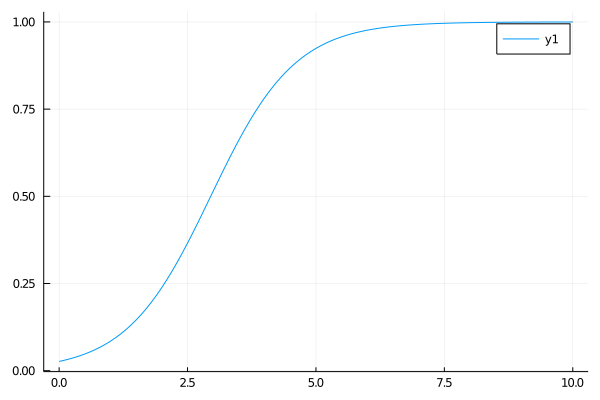

In [7]:

VL = 0:0.1:10
Plots.plot(VL,1 ./ (1 .+ exp.(0 .- LFD_PDcurve_b1*VL .- LFD_PDcurve_b0)))

In [9]:
-LFD_PDcurve_b0/LFD_PDcurve_b1

2.9508196721311477